# Params #  
X -> m-by-n matrix of net returns (samples-by-assets)  
r -> m-dimensional vec of net returns of index  
reg -> sparsity regularization parameter  
u -> upper bound of weights  
w_0 -> initial point  
p_neg_exp -> final negative exponent of p  
max_iter -> max number of iterations  

return n-dimensional vector w/ allocation weights on the assets  

In [3]:
# TODO: Build out simple backtesting framework along with graphs showing relative to tracked index
# TODO: Design functions to support backtest (i.e. gather data over previous time period and then view performance over the next 252 days, etc.)
# TODO: add support for dates in calculation methods
# TODO: Look into HUBER tracking errors for beating the S&P
# TODO: Add support for other indices besides S&P (maybe just simple if-else switches)
# TODO: may need to build out a backtest framework that will yield results over longer periods of time

In [4]:
import torch
import math
from sec import stock, constants, lookups
from polygon import RESTClient
import yfinance as yf # temporary until we figure out polygon api

In [5]:
constants.set_polygon_key("_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
poly_cli = RESTClient(api_key="_4BtZn3PRCLu6fsdu7dgddb4ucmB1sfp")
torch.set_default_dtype(torch.float64)

In [6]:
curr_sp = lookups.get_sp500_tickers()
print(len(curr_sp))
print(curr_sp)

503
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTLT', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DL

In [7]:
# aggregate all close data (has been modularized below)
# TODO: remove later after backtesting
close_data = torch.zeros((252, len(curr_sp)))

for i in range(len(curr_sp)):
    aggs = []
    data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_="2023-02-01", to = "2024-02-01")
    for j, agg in enumerate(data):
        close_data[j, i] = agg.close

print(close_data)

tensor([[155.4500,  16.6900, 156.8400,  ..., 328.6300,  53.3900, 167.8100],
        [155.5000,  17.0600, 155.2400,  ..., 344.7000,  54.2900, 171.0000],
        [154.5500,  17.0200, 152.1700,  ..., 330.8100,  54.4100, 167.8000],
        ...,
        [134.2800,  14.5300,  67.2500,  ..., 250.9100,  44.4400, 191.4300],
        [130.1000,  14.2300,  66.8500,  ..., 239.5500,  41.9000, 187.8100],
        [133.0500,  14.3400,  69.2400,  ..., 242.6000,  39.2500, 189.1400]])


In [8]:
torch.set_default_dtype(torch.float64)

col_dim = close_data.shape[0]
return_data = torch.zeros((252, len(curr_sp)))
for i in range(1, col_dim):
    return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
print(return_data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.2165e-04,  2.2169e-02, -1.0201e-02,  ...,  4.8900e-02,
          1.6857e-02,  1.9010e-02],
        [-5.7896e-03,  1.9772e-02, -2.9776e-02,  ...,  6.6336e-03,
          1.9105e-02, -5.9591e-05],
        ...,
        [-1.3619e-01, -1.2942e-01, -5.7122e-01,  ..., -2.3650e-01,
         -1.6763e-01,  1.4075e-01],
        [-1.6307e-01, -1.4739e-01, -5.7377e-01,  ..., -2.7106e-01,
         -2.1521e-01,  1.1918e-01],
        [-1.4410e-01, -1.4080e-01, -5.5853e-01,  ..., -2.6178e-01,
         -2.6484e-01,  1.2711e-01]])


In [9]:
def getCloseData():
    curr_sp = lookups.get_sp500_tickers()
    close_data = torch.zeros((252, len(curr_sp)))

    for i in range(len(curr_sp)):
        # aggs = []
        data = poly_cli.list_aggs(ticker=curr_sp[i], multiplier=1, timespan="day", from_="2023-02-01", to = "2024-02-01")
        for j, agg in enumerate(data):
            close_data[j, i] = agg.close
    return close_data

In [10]:
# curr_sp is current s&p tickers
# method simply retrieves close of certain ticker we specify
def getTickerClose(ticker, curr_sp, close_data):
    ix = curr_sp.index(ticker)
    print(close_data[:, ix])

# getTickerClose("AAPL", curr_sp, close_data)

In [11]:
def calculateTickerReturns():
    col_dim = close_data.shape[0]
    return_data = torch.zeros((252, len(curr_sp)))
    for i in range(1, col_dim):
        return_data[i] = (close_data[i, :] - close_data[0, :])/close_data[0, :]
    return return_data

In [12]:
def collectSP500():
    index_symbol = "^GSPC"
    index_data = yf.download(index_symbol, period="1y", interval="1d")
    index_close_data = torch.tensor(index_data["Close"].values)
    return index_close_data

In [13]:
def calculateIndexReturns():
    index_data = collectSP500()
    dim = index_data.shape[0]
    return_data = torch.zeros(252)
    for i in range(1, dim):
        return_data[i] = ((index_data[i] - index_data[0])) / index_data[0]
    return return_data.reshape(252, 1)

In [14]:
# TODO: currently subscription doesnt have access to index data; will come back
# aggs = []
# for a in poly_cli.list_aggs("I:SPX", 1, "day", "2023-03-10", "2023-05-12", limit=50000):
#     aggs.append(a)

# Algorithm #

In [15]:
# funcition to solve kkt
def bisection(c, u):
  n = len(c)
  w = torch.zeros(n) # new weight vector
  c_sort, sort_indices = torch.sort(c)
  
  high = n - 1
  low = 0

  while low <= high:
    mid = (low + high) // 2
    if mid == 0:
      break
    mu = -1/mid * (torch.sum(c_sort[0:mid]) + 2)

    cond1 = (mu + c_sort[mid] < 0).item()

    if mid < n:
      cond2 = torch.all((mu + c_sort[mid] >= 0)).item()
    else:
      cond2 = True

    if cond1 and cond2:
      break
    elif cond1 and not cond2:
      low = mid + 1
    else:
      high = mid - 1

  new_values = -(mu + c_sort[:mid] / 2)
  if torch.all(-(mu + c_sort[:mid])/2 <= u).item():
      # print(f"This is w.shape in bisection: {w.shape}")
      # print(f"This is what is getting put in w in bisecttion: {(-(mu + c_sort[:mid])/2).shape}")
      w[sort_indices[:mid]] = -(mu + c_sort[:mid])/2
      # print("We get to the if and this is executed")
      # print(w.shape)
      return w
  else:
    flag = False
    flag2 = False
    k = mid

    while True:
      low1 = 0
      high1 = k - 1

      while low1 <= high1:
        mid1 = (low1 + high1) // 2
        mu = (2 * mid1 * u - torch.sum(c_sort[mid1:k]) - 2) / (k - mid1)

        if mid1 != 0:
          cond1 = torch.all((mu + c_sort[mid1] <= -2*u)).item()
        else:
          cond1 = True

        cond2 = torch.all(((-2 * u) < (mu + c_sort[mid1]))).item() and torch.all(((mu + c_sort[k - 1]) < 0)).item()

        if k < n:
          cond3 = torch.all((mu + c_sort[k]) >= 0).item()
        else:
          cond3 = True

        if cond1 and cond2 and cond3:
          flag = True
          break
        elif cond1 and not cond2:
          low1 = mid1 + 1
        else:
          high1 = mid1 - 1

      if flag:
        break
      else:
        k = k + 1

      if k > n:
        flag2 = True
        break

    if flag2:
      num_elements = int(torch.ceil(torch.tensor(1/u)))
      w[sort_indices[:num_elements]] = u
    else:
      w[sort_indices[:mid1]] = u
      w[sort_indices[mid1:k]] = -(mu + c_sort[mid1:k]) / 2
    return w

In [16]:
# import torch

# def bisection(c, u):
#     n = len(c)
#     w = torch.zeros(n).reshape(503, 1)
#     c_sort, sort_indices = torch.sort(c)

#     high = n - 1
#     low = 0

#     while low <= high:
#         mid = (low + high) // 2
#         mu = -1/mid * (torch.sum(c_sort[:mid]) + 2)
#         print(mu)

#         tst1 = (mu + c_sort[mid - 1] < 0).item()
#         tst2 = (mu + c_sort[mid] >= 0).item() if mid < n else True

#         if tst1 and tst2:
#             break
#         elif tst1 and not tst2:
#             low = mid + 1
#         else:
#             high = mid - 1

#     if torch.all(-(mu + c_sort[:mid])/2 <= u):
#         print(w)
#         print(-(mu + c_sort[:mid])/2)
#         w[sort_indices[:mid]] = -(mu + c_sort[:mid])/2
#         print("Entered the if loop and this is w")
#         print(w)
#         return w
#     else:
#         flg = False
#         flg2 = False
#         k = mid

#         while True:
#             low1 = 0
#             high1 = k - 1

#             while low1 <= high1:
#                 mid1 = (low1 + high1) // 2
#                 if k - mid1 == 0:
#                     break
#                 mu = (2*mid1*u - torch.sum(c_sort[mid1:k]) - 2) / (k - mid1)

#                 tst1 = (mu + c_sort[mid1 - 1] <= -2*u).item() if mid1 != 0 else True
#                 tst2 = ((-2*u) < (mu + c_sort[mid1])).item() and ((mu + c_sort[k - 1]) < 0).item()

#                 tst3 = (mu + c_sort[k] >= 0).item() if k < n - 1 else True

#                 if tst1 and tst2 and tst3:
#                     flg = True
#                     break
#                 elif tst1 and not tst2:
#                     low1 = mid1 + 1
#                 else:
#                     high1 = mid1 - 1

#             if flg:
#                 break
#             else:
#                 k += 1

#             if k > n:
#                 flg2 = True
#                 break

#         if flg2:
#             num_elements = int(torch.ceil(1/u))
#             w[sort_indices[:num_elements]] = u
#         else:
#             w[sort_indices[:mid1]] = u
#             w[sort_indices[mid1:k]] = -(mu + c_sort[mid1:k])/2

#         return w


In [17]:
# increasing the weight
def eteMMupdate(w, B, b, Lmax_A, reg, p , c_1, u):
  d = reg / ((p + abs(w)) * c_1)
  c = B @ w + 1/Lmax_A * (b + d) # calculation for q_ete, tracking error, 503 x 503 @ 503 x 1 + 
  
  # print(f"This is c.shape {c.shape}")
  c = c.reshape(503)
  # print(f"This is c after reshape in eteMMupdate {c.shape}")

  return bisection(c,u)

In [18]:
def track(data, returns, reg, thres = 1e-9, u = 1, w_0 = None, p_neg_exp = 7, max_iter = 1000):
  X = data
  n = X.shape[1] # assets
  m = X.shape[0] # time

  if n == 1:
    print("Must track more than one asset")

  
  w_0 = (torch.ones(n) / n).reshape(503,1) # w_0 ~ Normal
  # print(w_0)
  # print(f"This is {w_0.shape}")

  F_v = torch.zeros((max_iter, 1))

  K = 10
  p_1 = 1 # initial p
  p_k = p_neg_exp # final p
  gamma = (p_k/p_1)**(1/K) # getting deci root
  seq = torch.arange(0, K + 1) # sequential tensor : [0, 1, ... , k]
  exp = gamma**seq # raising gamma to the above sequence (essentially reversing from 1 to p_k) of equiratio intervals
  p_p = p_1 * exp
  p_p = 10**(-p_p) # applying negative base-10 logarithmic transformation, log_10 (p_p)

  p_p_div_10 = p_p/10
  ones = 1e-3 * torch.ones_like(p_p)
  tol = torch.min(p_p_div_10, ones) # tolerance for convergence for early stopping

  k = 0 # iter tracker

  # Using Empirical Tracking Error

  A = 1/m * torch.transpose(X, 0, 1) @ X # building N x N matrix scaled by 1/m

  eigenvalues, _ = torch.linalg.eigh(A) # calculated eigenvalue of A
  Lmax_A = eigenvalues[-1] # retrieving maximum eigenvalue

  B = 2/Lmax_A * (A - Lmax_A * torch.eye(n)) # scaled eigenvector corresponding to Lmax_A
  b = -2/m * torch.transpose(X, 0, 1) @ returns # N x M @ M x 1 = N x 1

  # => Bw_(k) + reg * d_(p,u) + b

  for i in range(1,K+1):
    p = p_p[i]
    c_1 = torch.log(1 + u/p)
    flag = True
    while True:
      k = k + 1
      if k >= max_iter - 1:
        break

      # accelerated scheme for faster convergence (taking a double step)
      w_1 = eteMMupdate(w_0, B, b, Lmax_A, reg, p, c_1, u)
      w_1 = w_1.reshape(503, 1)
      w_2 = eteMMupdate(w_1, B, b, Lmax_A, reg, p, c_1, u)
      w_2 = w_2.reshape(503, 1)
      R = w_1 - w_0
      U = w_2 - w_1 - R
      norm_R = torch.norm(R, p=2)
      norm_U = torch.norm(U, p=2)

      a = max(min(-norm_R / norm_U, -1), -300)

      while True:
        if abs(a + 1) < 1e-6:
          w = w_2
          F_v[k - 1] = 1/reg * torch.norm(torch.matmul(X, w) - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))
          w_0 = w
          break

        w = w_0 - 2 * a * R + a**2 * U
        w = w.reshape(503)
        # print(f"This is w before the bisection: {w}")
        w = w.reshape(503, 1)
        w = bisection(-2 * w, u)
        w = w.reshape(503)
        # print(f"This is w after the bisection: {w}")
        w = w.reshape(503, 1)
        F_v[k - 1] = 1/reg * torch.norm(X @ w - returns)**2 + m/c_1 * torch.sum(torch.log(1 + w/p))

        if flag == 0 and F_v[k - 1] * (1 - torch.sign(F_v[k - 1]) * 1e-9) >= F_v[max(k - 2, 0)]:
          a = (a - 1) / 2
        else:
          w_0 = w
          break

      if flag == 0:
        rel_change = torch.abs(F_v[k - 1] - F_v[k - 2]) / max(1, abs(F_v[k - 1]))

        if rel_change <= tol[i] or k >= max_iter - 1:
          break
      flag = 0
      
  w[w < thres] = 0
  w = w / sum(w)
  return w.reshape(503)


# Training #

In [19]:
ticker_returns = calculateTickerReturns()
index_returns = calculateIndexReturns()

print(ticker_returns[0:5])
print(index_returns[0:5])

[*********************100%%**********************]  1 of 1 completed

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.2165e-04,  2.2169e-02, -1.0201e-02,  ...,  4.8900e-02,
          1.6857e-02,  1.9010e-02],
        [-5.7896e-03,  1.9772e-02, -2.9776e-02,  ...,  6.6336e-03,
          1.9105e-02, -5.9591e-05],
        [-2.0650e-02,  1.3781e-02, -3.2964e-02,  ..., -1.1959e-02,
          1.3298e-02, -1.7162e-02],
        [-6.0470e-03,  1.6177e-02, -3.4239e-02,  ...,  7.6682e-03,
          2.6222e-02, -1.3348e-02]])
tensor([[ 0.0000],
        [ 0.0130],
        [-0.0037],
        [-0.0007],
        [ 0.0049]])


In [20]:
# bisection algorithm issues (tensor containing more than one value and being ambiguous)
portfolio_weighting = track(ticker_returns, index_returns, reg=0.2)

In [37]:
tickers = []
for i in range(len(portfolio_weighting)):
    if portfolio_weighting[i] > 0:
        tickers.append(curr_sp[i])
print(len(tickers))

149


# Backtesting

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [49]:
weights_df = pd.DataFrame(portfolio_weighting.numpy())
returns_df = pd.DataFrame(ticker_returns.numpy())

index_returns_df = pd.DataFrame(index_returns.numpy())

In [28]:
weights_df

,0
0,0.000000
1,0.000000
2,0.000000
3,0.010276
4,0.000000
...,...
498,0.000000
499,0.000000
500,0.000000
501,0.000000


In [29]:
returns_df

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,500,501,502
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000322,0.022169,-0.010201,0.037063,-0.012005,-0.016020,0.003845,-0.044095,0.037024,0.021645,...,-0.013037,-0.000718,-0.031288,0.058164,0.009626,-0.006201,-0.003052,0.048900,0.016857,0.019010
2,-0.005790,0.019772,-0.029776,0.062367,-0.009550,-0.026824,-0.000268,-0.045497,0.019817,-0.011956,...,-0.013037,-0.023416,-0.024577,0.025614,0.003145,-0.015503,0.012911,0.006634,0.019105,-0.000060
3,-0.020650,0.013781,-0.032964,0.043320,-0.010778,-0.040733,-0.009569,-0.031474,0.003103,-0.022635,...,-0.013229,-0.011636,-0.026233,0.016275,-0.008292,0.000388,0.005634,-0.011959,0.013298,-0.017162
4,-0.006047,0.016177,-0.034239,0.063398,-0.009959,-0.026451,0.001520,-0.012621,0.014880,-0.000260,...,-0.007477,-0.010487,0.001569,0.030950,0.027164,0.002558,0.024570,0.007668,0.026222,-0.013348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,-0.157350,-0.093469,-0.577595,0.323111,0.121419,-1.000000,0.001699,0.244936,0.308427,0.599109,...,-0.072757,-0.146818,-0.102318,-0.068303,0.071197,0.000620,-0.047809,-0.232663,-0.175501,0.141291
248,-0.145513,-0.104853,-0.573068,0.318366,0.118076,-1.000000,0.014577,0.242287,0.316467,0.641566,...,-0.069594,-0.142939,-0.101185,-0.054963,0.080442,0.011937,-0.038185,-0.221221,-0.158457,0.148680
249,-0.136185,-0.129419,-0.571219,0.292993,0.124966,-1.000000,0.014845,0.255531,0.309238,0.635653,...,-0.089436,-0.141503,-0.086195,-0.065368,0.084159,0.012480,-0.042488,-0.236497,-0.167634,0.140754
250,-0.163075,-0.147394,-0.573769,0.267964,0.121419,-1.000000,0.011894,0.284356,0.283075,0.609137,...,-0.094804,-0.139922,-0.103974,-0.072839,0.071674,0.003721,-0.017214,-0.271065,-0.215209,0.119182


In [33]:
non_zero_weights = weights_df[weights_df > 0].dropna()
filtered_returns_df = returns_df.loc[:, non_zero_weights.index]

In [35]:
filtered_returns_df

,3,7,8,9,10,19,20,21,27,29,...,469,470,472,476,482,485,486,487,490,502
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.037063,-0.044095,0.037024,0.021645,0.015346,0.010057,-0.008152,0.018977,0.044114,0.043360,...,0.019740,0.015530,-0.042519,0.009380,0.018563,-0.026358,0.010986,-0.007258,0.037888,0.019010
2,0.062367,-0.045497,0.019817,-0.011956,0.012628,0.010435,-0.014214,-0.002791,0.008151,0.017131,...,-0.002012,-0.021992,-0.051218,0.010050,0.012553,-0.021695,0.006905,-0.020459,0.004750,-0.000060
3,0.043320,-0.031474,0.003103,-0.022635,0.005436,0.006654,-0.008814,-0.023331,-0.011092,-0.011342,...,-0.012507,-0.039259,-0.039083,0.003254,-0.004808,-0.016774,-0.005022,-0.027580,-0.012593,-0.017162
4,0.063398,-0.012621,0.014880,-0.000260,0.025086,0.025709,0.006063,-0.015852,0.012688,0.015005,...,0.001468,-0.034155,-0.027516,0.010145,0.000534,-0.019947,0.007847,-0.025506,0.002909,-0.013348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.323111,0.244936,0.308427,0.599109,0.098194,0.290586,0.187233,0.373744,0.402403,1.094164,...,0.209201,0.325749,0.355848,0.244066,0.167067,0.203355,0.094476,0.135482,0.330535,0.141291
248,0.318366,0.242287,0.316467,0.641566,0.116711,0.280378,0.165580,0.390154,0.415679,1.101016,...,0.247322,0.328030,0.373657,0.255743,0.164129,0.200376,0.092593,0.140803,0.364189,0.148680
249,0.292993,0.255531,0.309238,0.635653,0.102780,0.286125,0.174699,0.391605,0.396857,1.032845,...,0.256458,0.336284,0.405995,0.270004,0.160924,0.211774,0.104834,0.144606,0.384771,0.140754
250,0.267964,0.284356,0.283075,0.609137,0.089303,0.269943,0.182800,0.375642,0.380556,0.981215,...,0.229050,0.311523,0.365966,0.259284,0.155315,0.202189,0.087884,0.142255,0.373504,0.119182


In [41]:
weighted_returns = filtered_returns_df.mul(non_zero_weights.values.flatten(), axis=1)
daily_portfolio_returns = weighted_returns.sum(axis = 1)

In [42]:
daily_portfolio_returns

0      0.000000
1      0.026574
2      0.012948
3      0.004163
4      0.022900
         ...   
247    0.580592
248    0.598824
249    0.598655
250    0.574224
251    0.600076
Length: 252, dtype: float64

In [51]:
index_returns_df

,0
0,0.000000
1,0.012982
2,-0.003695
3,-0.000721
4,0.004914
...,...
247,0.307154
248,0.303401
249,0.294951
250,0.303133


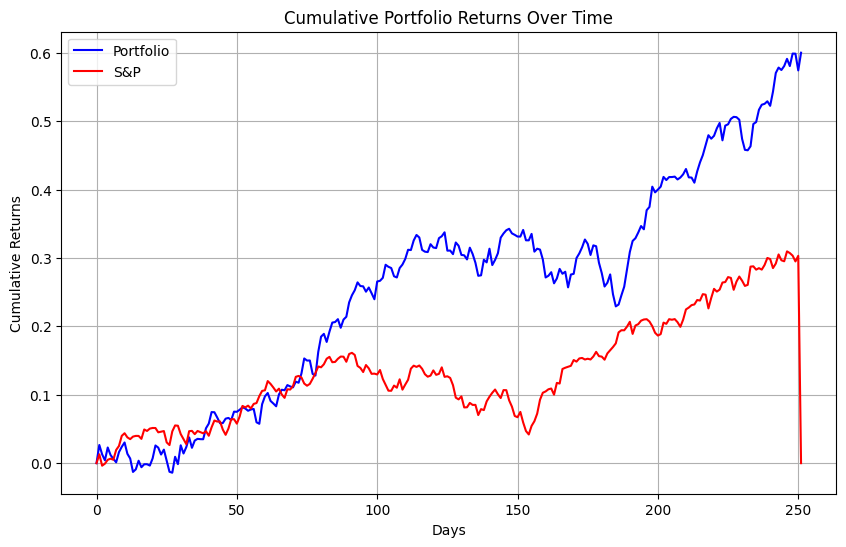

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(daily_portfolio_returns, label='Portfolio', color='blue')
plt.plot(index_returns_df, label="S&P", color='red')
plt.title('Cumulative Portfolio Returns Over Time')
plt.xlabel('Days')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
